Present assumptions:
- psuedobulked on CRE (removing MPRA barcode heterogenaity). 
- untransfected zeroes are detectable and have been removed
- Chimeric transcripts have been removed
- No systemic differences in cell number, tfection efficiency btwn reps (should change)
- There ARE systemic differences in dropout between replicates

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns

1000


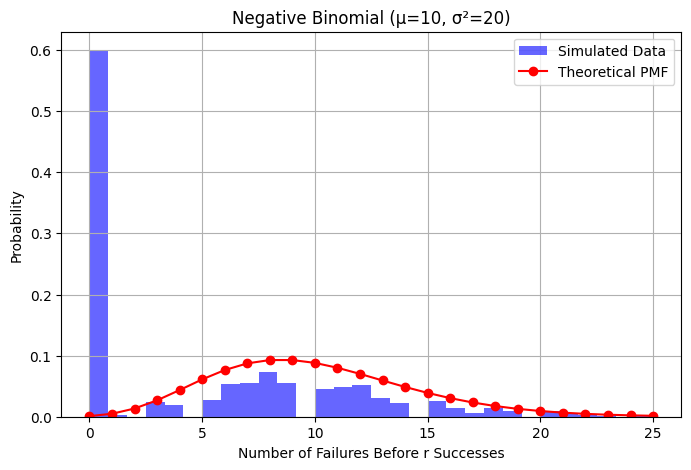

In [18]:

def plot_negative_binomial(samples, mu, sigma2):
    """
    Plot histogram and theoretical PMF of Negative Binomial distribution using mean and variance.
    """
    # Convert mean & variance to standard Negative Binomial parameters
    r = mu**2 / (sigma2 - mu)  # Number of successes
    p = mu / sigma2  # Probability of success

    plt.figure(figsize=(8, 5))
    plt.hist(samples, bins=30, density=True, alpha=0.6, color='b', label="Simulated Data")

    # Overlay theoretical Negative Binomial PMF
    x = np.arange(0, max(samples) + 1)
    pmf = stats.nbinom.pmf(x, r, p)
    plt.plot(x, pmf, 'ro-', label="Theoretical PMF")

    plt.xlabel("Number of Failures Before r Successes")
    plt.ylabel("Probability")
    plt.title(f"Negative Binomial (μ={mu}, σ²={sigma2})")
    plt.legend()
    plt.grid()
    plt.show()

def draw_nb(mu, sigma2, size):
    """
    Draw samples from a Negative Binomial distribution using mean and variance.

    Args:
        mu (float): Desired mean.
        sigma2 (float): Desired variance (must be > mu).
        size (int): Number of samples to draw.

    Returns:
        samples (array): Generated samples.
    """
    if sigma2 <= mu:
        raise ValueError("Variance must be greater than the mean (sigma² > μ)")

    # Convert mean & variance to standard Negative Binomial parameters
    r = mu**2 / (sigma2 - mu)  # Number of successes
    p = mu / sigma2  # Probability of success

    samples = np.random.negative_binomial(n=r, p=p, size=size)
    
    return samples

def draw_zinb(mu, sigma2, zin, size):
    """
        Args:
            mu (float): Desired mean.
            sigma2 (float): Desired variance (must be > mu).
            zin (float): 0-1 Desired fraction zero inflation. 
            size (int): Number of samples to draw.
    """

    zin_size=round(size*zin)
    non_zin_size=size-zin_size
    
    zerolist=pd.Series([0]*zin_size)
    draws=draw_nb(mu=mu,sigma2=sigma2,size=non_zin_size)

    return np.concatenate([zerolist,draws])

# Example usage:
mu = 10  # Mean
sigma2 = 20  # Variance
samples = draw_zinb(mu, sigma2,zin=0.5,size=1000)
print(len(samples))
plot_negative_binomial(samples, mu, sigma2)

In [19]:
data = {
    "CRE": ["nobody", "somebody", "everybody", "redgene", "neurogene", "nobody", "somebody", "everybody", "redgene", "neurogene"],
    "Cell-type": ["brain", "brain", "brain", "brain", "brain", "blood", "blood", "blood", "blood", "blood"],
    "mean": [1, 10, 114, 30, 99, 2, 12, 109, 112, 16]
}

# Creating the dataframe
cres = pd.DataFrame(data)

<Axes: xlabel='Cell-type', ylabel='mean'>

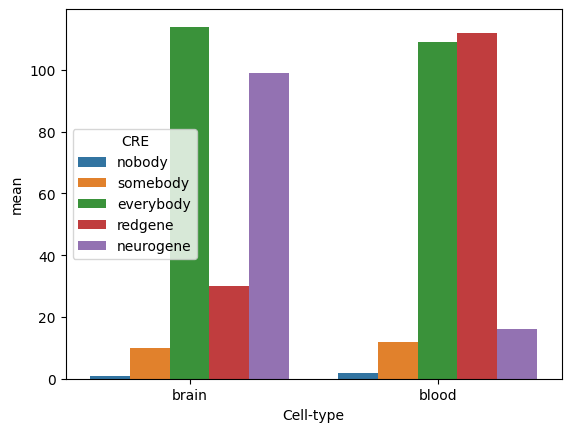

In [64]:
sns.barplot(cres,x="Cell-type",hue="CRE",y="mean")

In [21]:
#add variance column


np.random.seed(42) # so it's the same every time
cres["variance_constant"] = np.random.normal(loc=0.3, scale=0.1, size=len(cres))
cres["sigmasquare"]=cres["mean"]+cres["variance_constant"]*cres["mean"]**2

In [22]:
cres

,CRE,Cell-type,mean,variance_constant,sigmasquare
0,nobody,brain,1,0.349671,1.349671
1,somebody,brain,10,0.286174,38.617357
2,everybody,brain,114,0.364769,4854.536024
3,redgene,brain,30,0.452303,437.072687
4,neurogene,brain,99,0.276585,2809.806277
5,nobody,blood,2,0.276586,3.106345
6,somebody,blood,12,0.457921,77.940665
7,everybody,blood,109,0.376743,4585.089202
8,redgene,blood,112,0.253053,3286.291330
9,neurogene,blood,16,0.354256,106.689537


In [23]:
#add alterantive parametrization
cres["r"]=cres["mean"]**2/(cres["sigmasquare"]-cres["mean"])#also equal to 1/cres["variance_constant"]
cres["p"]=cres["mean"]/cres["sigmasquare"]

In [24]:
cres

,CRE,Cell-type,mean,variance_constant,sigmasquare,r,p
0,nobody,brain,1,0.349671,1.349671,2.859828,0.740921
1,somebody,brain,10,0.286174,38.617357,3.494383,0.258951
2,everybody,brain,114,0.364769,4854.536024,2.741462,0.023483
3,redgene,brain,30,0.452303,437.072687,2.210907,0.068638
4,neurogene,brain,99,0.276585,2809.806277,3.615529,0.035234
5,nobody,blood,2,0.276586,3.106345,3.615508,0.643843
6,somebody,blood,12,0.457921,77.940665,2.183781,0.153963
7,everybody,blood,109,0.376743,4585.089202,2.654326,0.023773
8,redgene,blood,112,0.253053,3286.291330,3.951748,0.034081
9,neurogene,blood,16,0.354256,106.689537,2.822817,0.149968


In [27]:
# at this point, we have all of the information that would be replicate-indepndent. 
# Let's duplicate the table vertically to simulate 

total_reps=3
cres_duplicated = pd.concat([cres] * total_reps, ignore_index=True)
cres_duplicated['replicate_ID'] = [i + 1 for i in range(total_reps) for _ in range(len(cres))]

In [29]:
cres_duplicated

,CRE,Cell-type,mean,variance_constant,sigmasquare,r,p,replicate_ID
0,nobody,brain,1,0.349671,1.349671,2.859828,0.740921,1
1,somebody,brain,10,0.286174,38.617357,3.494383,0.258951,1
2,everybody,brain,114,0.364769,4854.536024,2.741462,0.023483,1
3,redgene,brain,30,0.452303,437.072687,2.210907,0.068638,1
4,neurogene,brain,99,0.276585,2809.806277,3.615529,0.035234,1
5,nobody,blood,2,0.276586,3.106345,3.615508,0.643843,1
6,somebody,blood,12,0.457921,77.940665,2.183781,0.153963,1
7,everybody,blood,109,0.376743,4585.089202,2.654326,0.023773,1
8,redgene,blood,112,0.253053,3286.291330,3.951748,0.034081,1
9,neurogene,blood,16,0.354256,106.689537,2.822817,0.149968,1


In [30]:
cres=cres_duplicated

In [31]:
#let's pretend..
#In each replicate there were 1000 blood cells and 900 brain cells, and transfection efficiency for each CRE ~ N(0.5,0.01)
#to be more sophisticated, we could introduce systemic differences in cell number, tfection efficiency btwn reps...
np.random.seed(413) # so it's the same every time
cres["transfection_efficiency"]=np.random.normal(loc=0.5, scale=0.01, size=len(cres))
cres["cells"]=cres["Cell-type"].map({"brain":900,"blood":1000})*cres["transfection_efficiency"]
cres["cells"]=cres["cells"].round().astype(int)

In [49]:

#add zero inflation column
#this represents dropout due to RNA degredation, etc
#RNA dropout for each CRE ~ N(x,0.01) for rep 1 x=0.8, rep 2 x=0.5, rep3 x=0.9

np.random.seed(24) # so it's the same every time

zeroinfl=[]
for infl in [0.8,0.5,0.9]:
    zeroinfl.append(np.random.normal(loc=infl, scale=0.01, size=int(len(cres)/3)))

cres["zeroinfl"]=np.concatenate(zeroinfl)


In [50]:
cres

,CRE,Cell-type,mean,variance_constant,sigmasquare,r,p,replicate_ID,transfection_efficiency,cells,zeroinfl
0,nobody,brain,1,0.349671,1.349671,2.859828,0.740921,1,0.488506,440,0.813292
1,somebody,brain,10,0.286174,38.617357,3.494383,0.258951,1,0.515676,464,0.792300
2,everybody,brain,114,0.364769,4854.536024,2.741462,0.023483,1,0.501541,451,0.796837
3,redgene,brain,30,0.452303,437.072687,2.210907,0.068638,1,0.492430,443,0.790092
4,neurogene,brain,99,0.276585,2809.806277,3.615529,0.035234,1,0.516259,465,0.789292
5,nobody,blood,2,0.276586,3.106345,3.615508,0.643843,1,0.499099,499,0.785613
6,somebody,blood,12,0.457921,77.940665,2.183781,0.153963,1,0.504306,504,0.805644
7,everybody,blood,109,0.376743,4585.089202,2.654326,0.023773,1,0.501417,501,0.802957
8,redgene,blood,112,0.253053,3286.291330,3.951748,0.034081,1,0.495357,495,0.783736
9,neurogene,blood,16,0.354256,106.689537,2.822817,0.149968,1,0.498538,499,0.802196


In [51]:
def wrapper(row):
    #print(type(row["cells"]))
    np.random.seed(612)
    return draw_zinb(mu=row["mean"], sigma2=row["sigmasquare"], zin=row["zeroinfl"], size=row["cells"])

cres["draws"]=cres.apply(wrapper,axis=1)


In [52]:
cres

,CRE,Cell-type,mean,variance_constant,sigmasquare,r,p,replicate_ID,transfection_efficiency,cells,zeroinfl,draws
0,nobody,brain,1,0.349671,1.349671,2.859828,0.740921,1,0.488506,440,0.813292,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,somebody,brain,10,0.286174,38.617357,3.494383,0.258951,1,0.515676,464,0.792300,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,everybody,brain,114,0.364769,4854.536024,2.741462,0.023483,1,0.501541,451,0.796837,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,redgene,brain,30,0.452303,437.072687,2.210907,0.068638,1,0.492430,443,0.790092,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,neurogene,brain,99,0.276585,2809.806277,3.615529,0.035234,1,0.516259,465,0.789292,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,nobody,blood,2,0.276586,3.106345,3.615508,0.643843,1,0.499099,499,0.785613,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,somebody,blood,12,0.457921,77.940665,2.183781,0.153963,1,0.504306,504,0.805644,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,everybody,blood,109,0.376743,4585.089202,2.654326,0.023773,1,0.501417,501,0.802957,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,redgene,blood,112,0.253053,3286.291330,3.951748,0.034081,1,0.495357,495,0.783736,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,neurogene,blood,16,0.354256,106.689537,2.822817,0.149968,1,0.498538,499,0.802196,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [55]:
#Subsetting to those data that will be accessible after the assay is performed.
cres_reduced=cres[["CRE","Cell-type","replicate_ID","draws"]]

In [56]:
cres_reduced

,CRE,Cell-type,replicate_ID,draws
0,nobody,brain,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,somebody,brain,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,everybody,brain,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,redgene,brain,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,neurogene,brain,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,nobody,blood,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,somebody,blood,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,everybody,blood,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,redgene,blood,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,neurogene,blood,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [57]:
cres_reduced=cres_reduced.explode('draws').reset_index(drop=True)

In [58]:
cres_reduced.rename({'draws':'umi_count'},axis=1,inplace=True)

In [59]:
cres_reduced

,CRE,Cell-type,replicate_ID,umi_count
0,nobody,brain,1,0
1,nobody,brain,1,0
2,nobody,brain,1,0
3,nobody,brain,1,0
4,nobody,brain,1,0
...,...,...,...,...
14307,neurogene,blood,3,14
14308,neurogene,blood,3,20
14309,neurogene,blood,3,5
14310,neurogene,blood,3,12


In [68]:
#R hates dashes
cres_reduced.rename({'Cell-type':'Cell_type'},axis=1).to_csv("fake_cres.csv")

In [61]:
agg=cres_reduced.groupby(["CRE","Cell-type"]).sum().reset_index()

In [62]:
agg

,CRE,Cell-type,replicate_ID,umi_count
0,everybody,blood,3041,40057
1,everybody,brain,2746,38697
2,neurogene,blood,2951,6346
3,neurogene,brain,2744,35592
4,nobody,blood,3005,770
5,nobody,brain,2649,377
6,redgene,blood,3050,41635
7,redgene,brain,2708,11646
8,somebody,blood,3042,5133
9,somebody,brain,2703,3529


<Axes: xlabel='Cell-type', ylabel='umi_count'>

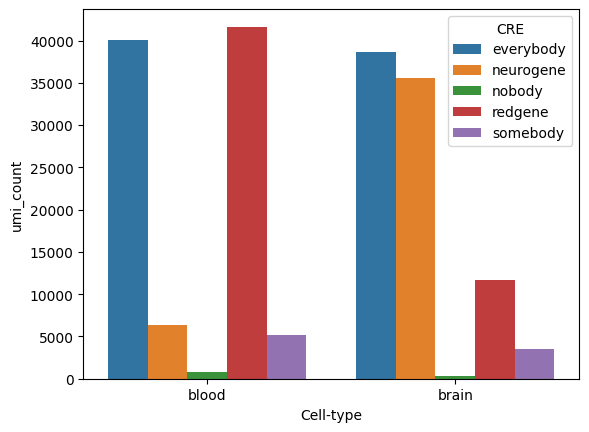

In [65]:
sns.barplot(agg,x="Cell-type",hue="CRE",y="umi_count")